
# Latent Dirichlet Allocation(LDA) for 'Customer interest' modelling


#### Import libraries

In [81]:
# !pip install pyLDAvis 

In [108]:
# import libraries 
import pandas as pd
import numpy as np
import re
import string
import spacy
import nltk
import gensim
from gensim import corpora

In [109]:
# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

####   Dataset Analysis

In [110]:
# Read data from csv
customer_review_data= pd.read_csv("E:\\code\\SENETIMENT_ANALYSIS_AMAZON\\LDATopicModelling\\amazon_alexa - amazon_alexa.csv")
print(customer_review_data.head(2))
print(len(customer_review_data))
print('Number of Unique variation')
print(len(customer_review_data.groupby('variation')))

   rating       date        variation verified_reviews  feedback
0       5  31-Jul-18  Charcoal Fabric    Love my Echo!         1
1       5  31-Jul-18  Charcoal Fabric        Loved it!         1
3150
Number of Unique variation
16


In [111]:
# Clean text
def clean_text(text ): 
    delete_dict = {sp_character: '' for sp_character in string.punctuation} 
    delete_dict[' '] = ' ' 
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    #print('cleaned:'+text1)
    textArr= text1.split()
    text2 = ' '.join([w for w in textArr if ( not w.isdigit() and  ( not w.isdigit() and len(w)>3))]) 
    return text2.lower()

In [112]:
# In natural language processing, useless words (data), are referred to as stop words. 
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [113]:
# Removes the rows that contains NULL values.
customer_review_data.dropna(axis = 0, how ='any',inplace=True) 
customer_review_data

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1
...,...,...,...,...,...
3145,5,30-Jul-18,Black Dot,"Perfect for kids, adults and everyone in betwe...",1
3146,5,30-Jul-18,Black Dot,"Listening to music, searching locations, check...",1
3147,5,30-Jul-18,Black Dot,"I do love these things, i have them running my...",1
3148,5,30-Jul-18,White Dot,Only complaint I have is that the sound qualit...,1


####   Filter short reviews according to rating

In [114]:
customer_review_data['verified_reviews'] = customer_review_data['verified_reviews'].apply(clean_text)
customer_review_data['Num_words_text'] = customer_review_data['verified_reviews'].apply(lambda x:len(str(x).split())) 

print('-------Dataset --------')
print(customer_review_data['rating'].value_counts())
print(len(customer_review_data))
print('-------------------------')
max_review_data_sentence_length  = customer_review_data['Num_words_text'].max()

mask = (customer_review_data['Num_words_text'] < 100) & (customer_review_data['Num_words_text'] >=20)
df_short_reviews = customer_review_data[mask]
df_new = df_short_reviews.groupby('rating').apply(lambda x: x.sample(n=40)).reset_index(drop = True)

print('No of Short reviews')
print(len(df_short_reviews))

-------Dataset --------
5    2246
4     447
1     146
3     140
2      92
Name: rating, dtype: int64
3071
-------------------------
No of Short reviews
640


In [115]:
df_short_reviews

,rating,date,variation,verified_reviews,feedback,Num_words_text
2,4,31-Jul-18,Walnut Finish,sometimes while playing game answer question c...,1,21
6,3,31-Jul-18,Sandstone Fabric,without having cellphone cannot many features ...,1,33
7,5,31-Jul-18,Charcoal Fabric,think this purchased working getting every roo...,1,22
12,5,30-Jul-18,Oak Finish,purchased this mother having knee problems giv...,1,30
17,5,30-Jul-18,Heather Gray Fabric,have only been using alexa couple days having ...,1,21
...,...,...,...,...,...,...
3101,5,30-Jul-18,Black Dot,these additional alexa based devices make acce...,1,27
3110,5,30-Jul-18,White Dot,love personally prefer spotify music it’s grea...,1,46
3129,4,30-Jul-18,White Dot,have these throughout home they great there ti...,1,38
3147,5,30-Jul-18,Black Dot,love these things have them running entire hom...,1,49


In [116]:
df_new

,rating,date,variation,verified_reviews,feedback,Num_words_text
0,1,30-Jul-18,White Dot,product sounded same emoji speaker from five b...,0,22
1,1,30-Jul-18,Black Show,waste money over echo generation don’t really ...,0,60
2,1,14-Jul-18,White Plus,will returning this piece garbage soon possibl...,0,76
3,1,24-Jul-18,White Spot,great product except there possible clock disp...,0,43
4,1,20-Jul-18,Black Plus,only purchase echo plus because built came wit...,0,58
...,...,...,...,...,...,...
195,5,29-Jul-18,Black Spot,perfect favorite alexa device specially ring c...,1,22
196,5,30-Jul-18,Black Spot,smaller than anticipated when that very much m...,1,26
197,5,30-Jul-18,Black Dot,have echo about weeks having with morning alar...,1,41
198,5,29-Jul-18,White Spot,love this product bedroom clock perfect size w...,1,24


####   Dataset Pre-processing

In [117]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

# function to remove stopwords
def remove_stopwords(text):
    textArr = text.split(' ')
    rem_text = " ".join([i for i in textArr if i not in stop_words])
    return rem_text

# remove stopwords from the text
df_new['verified_reviews']=df_new['verified_reviews'].apply(remove_stopwords)

In [118]:
nlp = spacy.load('en_core_web_md', disable=['parser', 'ner'])
# create a lemmatization for filtering
def lemmatization(texts,allowed_postags=['NOUN', 'ADJ']): 
       output = []
       for sent in texts:
             doc = nlp(sent) 
             output.append([token.lemma_ for token in doc if token.pos_ in allowed_postags ])
       return output

C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\catalogue\__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\catalogue\__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\catalogue\__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\catalogue\__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.g

C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\catalogue\__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\catalogue\__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\catalogue\__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\catalogue\__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.g

#### Finding Nouns and Adjectives

In [119]:
text_list=df_new['verified_reviews'].tolist()
print(text_list[1])
tokenized_reviews = lemmatization(text_list)
print(tokenized_reviews[1])

waste money echo generation don’t really anything video chat device would facetime skype cycle pictures slideshow mode sticks first photo leave matter even looked online research articles cannot find solution also problems device shutting problems echo devices price difference worth
['waste', 'money', 'echo', 'generation', 'video', 'chat', 'device', 'facetime', 'skype', 'cycle', 'picture', 'mode', 'stick', 'first', 'photo', 'matter', 'online', 'research', 'article', 'solution', 'device', 'problem', 'echo', 'device', 'price', 'difference', 'worth']


#### Dictionary and Document term matrix

In [120]:
# Create vocabulary dictionary and document term matrix
dictionary = corpora.Dictionary(tokenized_reviews)
doc_term_matrix = [dictionary.doc2bow(rev) for rev in tokenized_reviews]

####  LDA model

In [121]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

In [122]:
# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=34, random_state=10,
                chunksize=1000, passes=50,iterations=100)

In [123]:
lda_model.print_topics()

[(19,
  '0.040*"quality" + 0.035*"device" + 0.030*"product" + 0.030*"sound" + 0.025*"work" + 0.025*"echo" + 0.020*"reason" + 0.020*"nice" + 0.020*"time" + 0.020*"feature"'),
 (3,
  '0.041*"time" + 0.028*"bedside" + 0.028*"video" + 0.028*"garbage" + 0.028*"normal" + 0.028*"piece" + 0.028*"great" + 0.028*"echo" + 0.028*"figure" + 0.014*"front"'),
 (18,
  '0.039*"speaker" + 0.034*"voice" + 0.025*"bass" + 0.025*"little" + 0.025*"well" + 0.023*"good" + 0.017*"money" + 0.017*"surprised" + 0.017*"screen" + 0.017*"show"'),
 (5,
  '0.020*"echo" + 0.020*"clock" + 0.015*"thing" + 0.015*"time" + 0.015*"problem" + 0.015*"app" + 0.010*"room" + 0.010*"item" + 0.010*"work" + 0.010*"speed"'),
 (22,
  '0.030*"need" + 0.020*"able" + 0.020*"many" + 0.020*"home" + 0.020*"purchase" + 0.020*"amazon" + 0.020*"useless" + 0.020*"fine" + 0.010*"music" + 0.010*"auto"'),
 (11,
  '0.059*"show" + 0.040*"home" + 0.020*"price" + 0.020*"part" + 0.020*"sound" + 0.020*"fault" + 0.020*"option" + 0.020*"computer" + 0.020*"

#### Measureing the model

In [124]:
# a measure of how good the model is. lower the better.
print('\nPerplexity: ', lda_model.log_perplexity(doc_term_matrix,total_docs=100))

# Compute Coherence Score
from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_reviews, dictionary=dictionary , coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score:', coherence_lda)



Perplexity:  -9.147491133922994

Coherence Score: 0.39959832633670217


#### Visualize the topics

In [125]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, doc_term_matrix, dictionary)
vis

C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
5      0.022877 -0.036739       1        1  5.489154
19    -0.117645 -0.120386       2        1  5.485008
30    -0.062694 -0.068781       3        1  5.336107
13     0.000174 -0.090664       4        1  3.964035
33    -0.051204 -0.065006       5        1  3.918594
15    -0.078906  0.067854       6        1  3.918217
29    -0.095920  0.036530       7        1  3.898333
7     -0.030574 -0.041768       8        1  3.731368
25    -0.103990  0.098243       9        1  3.665013
0     -0.138322  0.078306      10        1  3.630795
6      0.062587 -0.098150      11        1  3.530393
32    -0.126280  0.052461      12        1  3.524092
24    -0.027891 -0.109673      13        1  3.506020
9      0.013970 -0.110374      14        1  3.058881
18     0.000717 -0.012661      15        1  3.023051
26    -0.101923  0.016936      16        1  3.009252
28     0.012190 -0.077919      17        1  2.846689
17     0.028611 -0.030945      18        1  2.769327
1      0.091526 -0.024688      19        1  2.591214
10     0.105577 -0.041141      20        1  2.554866
23     0.086663  0.023529      21        1  2.493430
14    -0.064741  0.036570      22        1  2.479428
22     0.023705  0.102429      23        1  2.447547
16     0.065945 -0.036292      24        1  2.355135
2      0.115843  0.085305      25        1  2.289105
31     0.096768  0.062970      26        1  2.154738
12     0.036635 -0.020481      27        1  2.118338
8      0.008222  0.037430      28        1  2.082526
4      0.009535  0.017780      29        1  1.955464
20     0.000734  0.031646      30        1  1.763377
3      0.030094  0.036147      31        1  1.559659
27     0.064547  0.080188      32        1  1.537539
11     0.049398  0.063259      33        1  0.870336
21     0.073774  0.058085      34        1  0.442971, topic_info=        Term       Freq      Total Category  logprob  loglift
9     device  57.000000  57.000000  Default   30.000  30.0000
4    speaker  34.000000  34.000000  Default   29.000  29.0000
438    sound  27.000000  27.000000  Default   28.000  28.0000
163    music  57.000000  57.000000  Default   27.000  27.0000
157     show  16.000000  16.000000  Default   26.000  26.0000
..       ...        ...        ...      ...      ...      ...
16      mode   0.010668   3.161247  Topic34   -7.146  -0.2721
17     money   0.010668  10.917439  Topic34   -7.146  -1.5115
18    online   0.010668   3.051353  Topic34   -7.146  -0.2367
19     photo   0.010668   1.530921  Topic34   -7.146   0.4530
20   picture   0.010668   3.918638  Topic34   -7.146  -0.4869

[1653 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
206       4  0.653202     1030pm
612      20  0.899755      342nd
757      19  0.684944      34hmm
175      11  0.773538       34im
219      27  0.692278      34the
...     ...       ...        ...
952      21  0.674621  zonkedout
498      22  0.680746      zwave
248       3  0.636737       zzzz
953      21  0.674621    zzzzzzz
323      28  0.690845        ’ve

[2158 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 20, 31, 14, 34, 16, 30, 8, 26, 1, 7, 33, 25, 10, 19, 27, 29, 18, 2, 11, 24, 15, 23, 17, 3, 32, 13, 9, 5, 21, 4, 28, 12, 22])

#### Finding the best model 

In [126]:
# Compute c_v coherence for various number of topics
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [127]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=doc_term_matrix, texts=tokenized_reviews, start=2, limit=50, step=1)

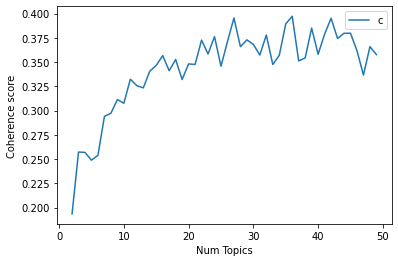

In [128]:
# Show graph
limit=50; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()# Print the coherence scores


In [142]:
# Print the coherence scores
max_coherence=0
optimal_topics=0
for m, cv in zip(x, coherence_values):
    if(max_coherence<cv):
        max_coherence=cv
        optimal_topics=m
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))
print("\n_____________________________________________________")   
print("Optimal Topic number =", optimal_topics, " Coherence Scores =", round(max_coherence, 4))

Num Topics = 2  has Coherence Value of 0.1935
Num Topics = 3  has Coherence Value of 0.2573
Num Topics = 4  has Coherence Value of 0.2569
Num Topics = 5  has Coherence Value of 0.2489
Num Topics = 6  has Coherence Value of 0.2539
Num Topics = 7  has Coherence Value of 0.294
Num Topics = 8  has Coherence Value of 0.2972
Num Topics = 9  has Coherence Value of 0.3113
Num Topics = 10  has Coherence Value of 0.3075
Num Topics = 11  has Coherence Value of 0.3323
Num Topics = 12  has Coherence Value of 0.3257
Num Topics = 13  has Coherence Value of 0.3234
Num Topics = 14  has Coherence Value of 0.3406
Num Topics = 15  has Coherence Value of 0.3466
Num Topics = 16  has Coherence Value of 0.3566
Num Topics = 17  has Coherence Value of 0.3411
Num Topics = 18  has Coherence Value of 0.3526
Num Topics = 19  has Coherence Value of 0.332
Num Topics = 20  has Coherence Value of 0.3481
Num Topics = 21  has Coherence Value of 0.3475
Num Topics = 22  has Coherence Value of 0.3727
Num Topics = 23  has Co

In [130]:
# Select the model and print the topics
optimal_model = model_list[32]
model_topics = optimal_model.show_topics(formatted=False)
optimal_model.print_topics(num_words=10)

[(6,
  '0.054*"free" + 0.048*"echo" + 0.044*"device" + 0.041*"bulb" + 0.041*"reminder" + 0.027*"purchase" + 0.025*"show" + 0.022*"sonos" + 0.014*"trigger" + 0.014*"timer"'),
 (4,
  '0.045*"music" + 0.024*"device" + 0.023*"thing" + 0.020*"product" + 0.017*"speaker" + 0.016*"camera" + 0.015*"room" + 0.012*"free" + 0.011*"prime" + 0.011*"reception"'),
 (11,
  '0.024*"light" + 0.024*"device" + 0.023*"music" + 0.023*"screen" + 0.022*"time" + 0.021*"voice" + 0.017*"good" + 0.017*"show" + 0.012*"news" + 0.012*"touch"'),
 (20,
  '0.029*"product" + 0.027*"month" + 0.022*"amazon" + 0.020*"good" + 0.019*"great" + 0.016*"warranty" + 0.015*"music" + 0.015*"stick" + 0.015*"echo" + 0.015*"fire"'),
 (27,
  '0.034*"device" + 0.024*"thing" + 0.023*"easy" + 0.017*"time" + 0.015*"many" + 0.015*"phone" + 0.015*"good" + 0.014*"help" + 0.014*"friend" + 0.014*"link"'),
 (2,
  '0.048*"device" + 0.020*"list" + 0.020*"time" + 0.018*"music" + 0.017*"room" + 0.017*"internet" + 0.017*"connection" + 0.017*"good" + 0

In [131]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(optimal_model, doc_term_matrix, dictionary)
vis

C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
25     0.129873  0.010783       1        1  6.434702
27     0.091921 -0.067911       2        1  5.303092
20     0.066496  0.031042       3        1  5.274484
2      0.082389 -0.006209       4        1  4.712366
4      0.104106  0.016894       5        1  4.461599
13     0.082736 -0.114137       6        1  4.290420
33     0.111209  0.022097       7        1  4.190085
28     0.075468 -0.104800       8        1  4.000816
11     0.054421 -0.009462       9        1  3.983948
24     0.045060  0.127148      10        1  3.962181
5      0.057503  0.073442      11        1  3.767377
29    -0.028465 -0.069135      12        1  3.670478
1     -0.002942  0.104675      13        1  3.500343
32     0.058141  0.076984      14        1  3.398948
18    -0.027944  0.095470      15        1  3.335269
23     0.040037 -0.044601      16        1  3.194224
3     -0.090461 -0.043160      17        1  2.850943
22     0.035328 -0.055378      18        1  2.802367
21     0.058381  0.023355      19        1  2.680747
14    -0.058064 -0.130539      20        1  2.647467
30     0.026717 -0.017844      21        1  2.573581
17    -0.099141 -0.139394      22        1  2.509220
12    -0.012240  0.013630      23        1  2.149859
16    -0.003638 -0.043566      24        1  1.889994
15    -0.146893  0.071591      25        1  1.721541
19    -0.091912  0.051465      26        1  1.719099
6     -0.068954 -0.085563      27        1  1.688975
26    -0.015325  0.036089      28        1  1.627900
7     -0.096497  0.042394      29        1  1.303248
9     -0.122031 -0.015654      30        1  1.245414
8     -0.064141  0.023659      31        1  1.194632
31    -0.094040  0.031956      32        1  0.801206
10     0.000762  0.070455      33        1  0.638080
0     -0.097860  0.024225      34        1  0.475397, topic_info=       Term      Freq      Total Category  logprob  loglift
65     time  40.00000  40.000000  Default  30.0000  30.0000
9    device  56.00000  56.000000  Default  29.0000  29.0000
438   sound  27.00000  27.000000  Default  28.0000  28.0000
152    work  24.00000  24.000000  Default  27.0000  27.0000
11     echo  32.00000  32.000000  Default  26.0000  26.0000
..      ...       ...        ...      ...      ...      ...
15   matter   0.01115   1.522031  Topic34  -7.1724   0.4324
16     mode   0.01115   3.117815  Topic34  -7.1724  -0.2846
17    money   0.01115   9.622563  Topic34  -7.1724  -1.4116
18   online   0.01115   2.955689  Topic34  -7.1724  -0.2312
19    photo   0.01115   1.515909  Topic34  -7.1724   0.4365

[1650 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
206      10  0.639868     1030pm
833       2  0.668557      24ghz
612       7  0.425081      342nd
612      14  0.425081      342nd
757      11  0.581822      34hmm
...     ...       ...        ...
952      12  0.619309  zonkedout
498       8  0.626090      zwave
248       6  0.652280       zzzz
953      12  0.619283    zzzzzzz
323      30  0.719067        ’ve

[2162 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[26, 28, 21, 3, 5, 14, 34, 29, 12, 25, 6, 30, 2, 33, 19, 24, 4, 23, 22, 15, 31, 18, 13, 17, 16, 20, 7, 27, 8, 10, 9, 32, 11, 1])

#### Predict new review using trained model

In [145]:
# Enter customer review
input_review="I have again removed more please-help begging from your question. Note that we prefer a technical style of writing here. We gently discourage greetings, hope-you-can-helps, thanks, advance thanks, notes of appreciation, regards, kind regards, signatures, please-can-you-helps, chatty material and abbreviated txtspk, pleading, how long you've been stuck, voting advice, meta commentary, etc. Just explain your problem, and show what you've tried, what you expected, and what actually happened"

In [146]:
# Predicting the topic distribution for the given review
input_testing_review_list=[""]
input_testing_review_list[0]=input_review
tokenized_testing_reviews = lemmatization(input_testing_review_list)

# Tokenized_testing_reviews
new_doc_bow = dictionary.doc2bow(tokenized_reviews[0])
lda_model.get_document_topics(new_doc_bow)

#Topic_id ,Probability

[(16, 0.8613428)]